In [43]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set up matplotlib style 
plt.style.use('ggplot')

# Libraries for wordcloud making and image importing
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image

# And libraries for data transformation
import datetime
from string import punctuation

#words counter
from collections import Counter
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import spacy
from nltk.tokenize import word_tokenize 

#model
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from itertools import compress
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import graphviz
from matplotlib import pyplot as plt
from pdpbox import pdp, get_dataset, info_plots
import shap


In [44]:
#import data
data = pd.read_csv('../output/google_homemini450.csv')
data.info()
# Data overlook
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4500 entries, 0 to 4499
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   rating            4500 non-null   float64
 1   date              4500 non-null   object 
 2   shop              4500 non-null   object 
 3   title             4500 non-null   object 
 4   verified_reviews  4499 non-null   object 
dtypes: float64(1), object(4)
memory usage: 175.9+ KB


,rating,date,shop,title,verified_reviews
0,5.0,3 months ago,lowes.com,"Great way to get started with a ""smart home""","Not only has this been fun to use, it's making..."
1,5.0,3 months ago,lowes.com,Functional small speaker with big sound,The “Smart Light Starter Kit” consists of 2 pr...
2,5.0,8 months ago,Best Buy,Solid Combo Makes a Good Smart Home Starting P...,If you're invested in the Google ecosystem and...
3,1.0,2 months ago,lowes.com,I don't know what went wrong??? Bulb doesn't work,I bought the kit on Black Friday 2019 for $20 ...
4,4.0,4 months ago,lowes.com,Nice if you don't mind privacy issues,"First off, let's be clear. The kit includes a ..."


In [45]:
# Transform string data and remove punctuation
data['verified_reviews'] = data.verified_reviews.apply(lambda x: str(x).lower())
data['verified_reviews'] = data.verified_reviews.apply(lambda x: ''.join([c for c in x if c not in punctuation]))

In [46]:
# Get length of review for EDA
data['review_length'] = data.verified_reviews.apply(lambda x: len(x))

In [47]:
# Check the data again
data.head()

,rating,date,shop,title,verified_reviews,review_length
0,5.0,3 months ago,lowes.com,"Great way to get started with a ""smart home""",not only has this been fun to use its making m...,2672
1,5.0,3 months ago,lowes.com,Functional small speaker with big sound,the “smart light starter kit” consists of 2 pr...,4423
2,5.0,8 months ago,Best Buy,Solid Combo Makes a Good Smart Home Starting P...,if youre invested in the google ecosystem and ...,2487
3,1.0,2 months ago,lowes.com,I don't know what went wrong??? Bulb doesn't work,i bought the kit on black friday 2019 for 20 b...,2248
4,4.0,4 months ago,lowes.com,Nice if you don't mind privacy issues,first off lets be clear the kit includes a sma...,2413


In [48]:
# Take a look at the mean, standard deviation, and maximum
print('The mean for the length of review:',data['review_length'].mean())
print('The standard deviation for the length of reviews:',data['review_length'].std())
print('The maximum for the length of reviews:',data['review_length'].max())

The mean for the length of review: 442.8666666666667
The standard deviation for the length of reviews: 382.0237189034805
The maximum for the length of reviews: 6410


Text(0.5, 1.0, 'Distribution of review length')

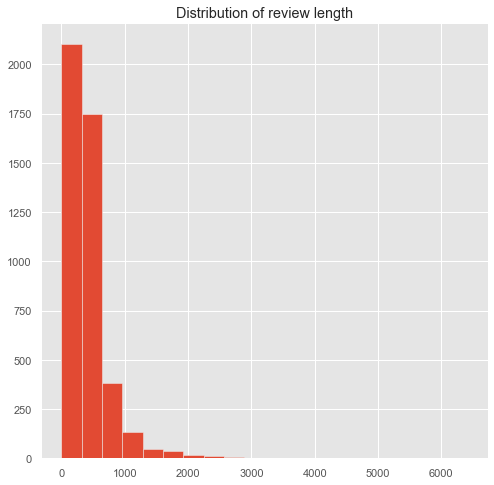

In [49]:
# And take a look at the distribution of the length
data['review_length'].hist(bins=20)
plt.title('Distribution of review length')

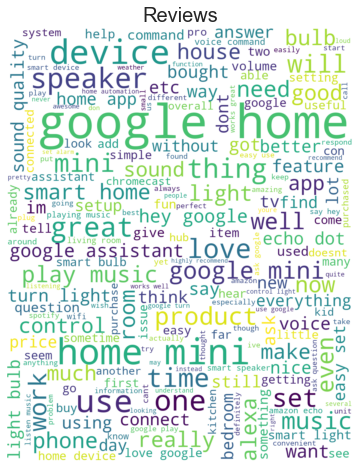

In [50]:
#words cloud of most comman words 
A = np.array(Image.open('../input/google_homemini.png'))
np.random.seed(321)
sns.set(rc={'figure.figsize':(8,8)})
reviews = ' '.join(data['verified_reviews'].tolist())

wordcloud = WordCloud(mask=A,background_color="white").generate(reviews)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.title('Reviews',size=20)
plt.show()

Text(0.5, 1.0, 'Counts of each shops')

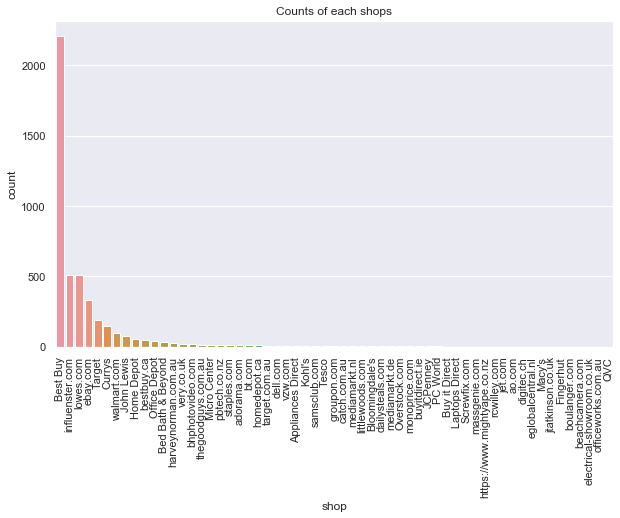

In [51]:
#reviews on shops 
sns.set(rc={'figure.figsize':(10,6)})
sns.countplot(data.shop,
              order = data['shop'].value_counts().index)
plt.xticks(rotation=90)
plt.title('Counts of each shops')

Best Buy               2209
influenster.com         513
lowes.com               512
ebay.com                334
Target                  193
Currys                  146
walmart.com              99
John Lewis               74
Home Depot               56
bestbuy.ca               46
Office Depot             42
Bed Bath & Beyond        33
harveynorman.com.au      26
very.co.uk               18
bhphotovideo.com         16
Name: shop, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4317 entries, 0 to 4499
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   rating            4317 non-null   float64
 1   date              4317 non-null   object 
 2   shop              4317 non-null   object 
 3   title             4317 non-null   object 
 4   verified_reviews  4317 non-null   object 
 5   review_length     4317 non-null   int64  
dtypes: float64(1), int64(1), object(4)
memory usage: 236.1+ KB


Text(0.5, 1.0, 'Counts of each shops')

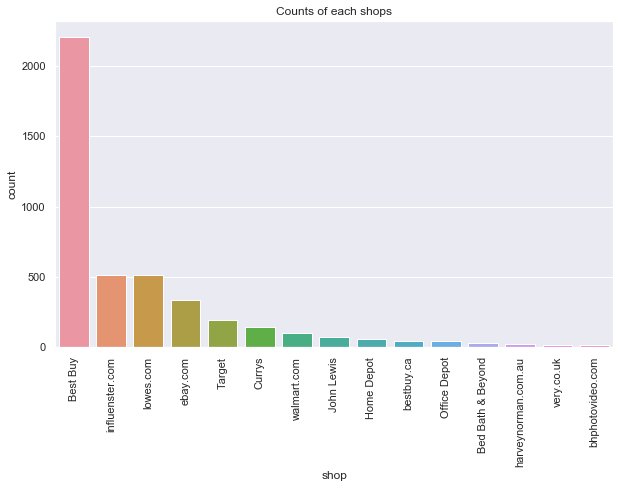

In [52]:
#reviews on top 15 shops 
top15 = data['shop'].value_counts().nlargest(15)
print(top15)
data = data[data['shop'].isin(top15.index)]
data.info()
sns.set(rc={'figure.figsize':(10,6)})
sns.countplot(data.shop,
              order = data['shop'].value_counts().index)
plt.xticks(rotation=90)
plt.title('Counts of each shops')

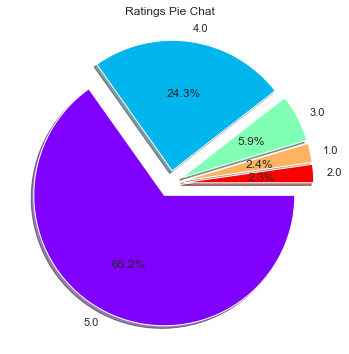

In [53]:
import matplotlib.cm as cm

#count data rating
counts = data.rating.value_counts()
#rating pie
values = counts.values
labels = counts.index
explode = (0.1, 0.1, 0.1, 0.1, 0.1)
colors = cm.rainbow(np.linspace(0, 1, len(labels)))
plt.pie(values, 
        colors=colors, 
        labels=labels,
        explode=explode, 
        autopct='%1.1f%%',
        counterclock=False,
        shadow=True)
plt.title('Ratings Pie Chat')
plt.show()

In [54]:
data5 = data[data.rating == 5]
data_not_5 = data[data.rating != 5]
data1 = data[data.rating == 1]

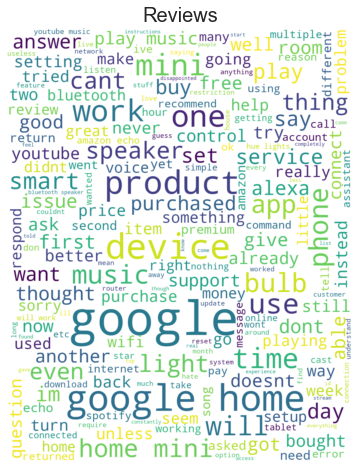

In [55]:
#words cloud of most comman words for rating 1
A = np.array(Image.open('../input/google_homemini.png'))
np.random.seed(321)
sns.set(rc={'figure.figsize':(8,8)})
reviews = ' '.join(data1['verified_reviews'].tolist())

wordcloud = WordCloud(mask=A,background_color="white").generate(reviews)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.title('Reviews',size=20)
plt.show()

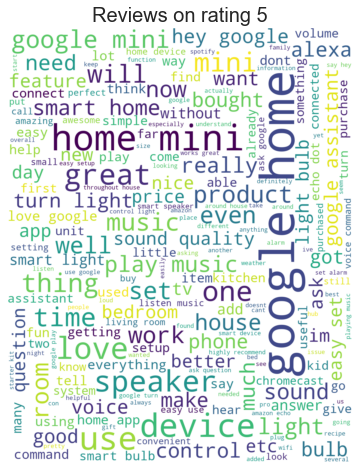

In [56]:
#words cloud of most comman words for rating 5
A = np.array(Image.open('../input/google_homemini.png'))
np.random.seed(321)
sns.set(rc={'figure.figsize':(8,8)})
reviews = ' '.join(data5['verified_reviews'].tolist())

wordcloud = WordCloud(mask=A,background_color="white").generate(reviews)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.title('Reviews on rating 5',size=20)
plt.show()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text xticklabel objects>)

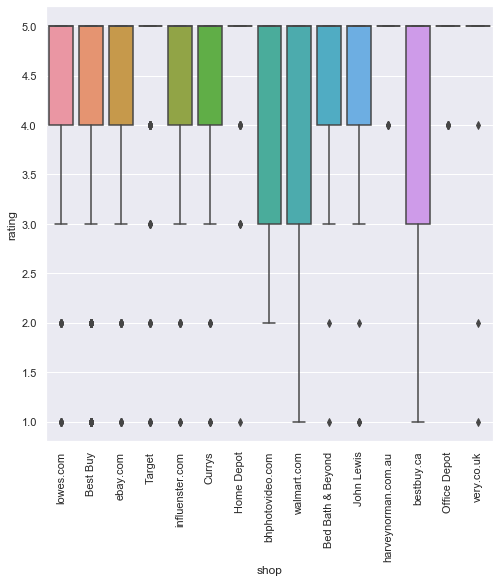

In [57]:
#relationship between rating and shop
sns.boxplot(data.shop, data.rating)
plt.xticks(rotation = 90)

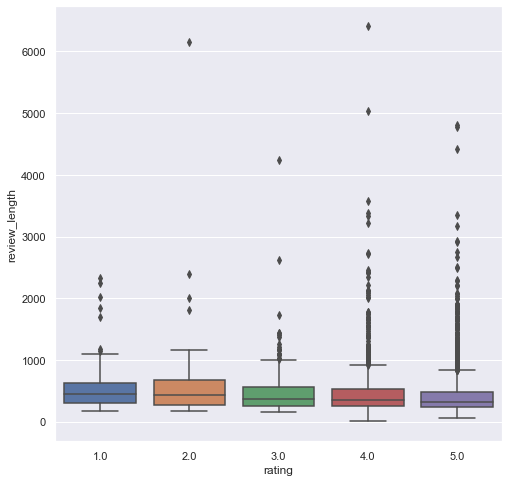

In [58]:
#relationship between rating and reviews lenth
sns.boxplot('rating','review_length',data=data)


In [59]:
data['log_review_length'] = data.review_length.apply(lambda x: (np.log(x)+1))


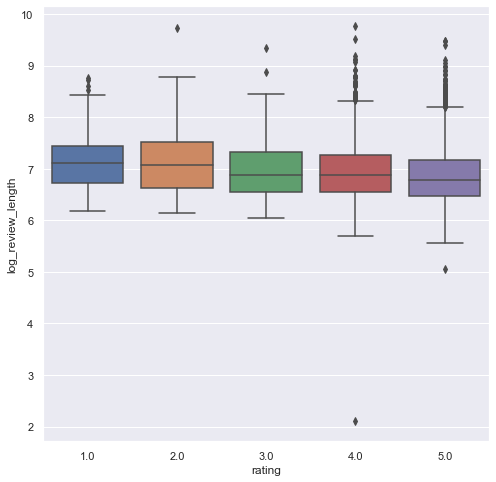

In [60]:
sns.boxplot('rating','log_review_length',data=data)


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text xticklabel objects>)

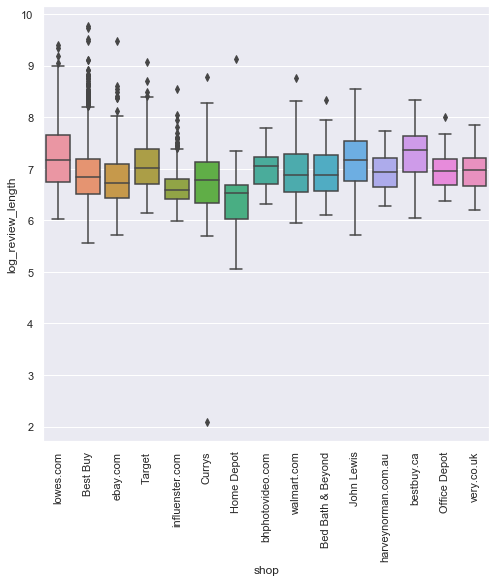

In [62]:
sns.boxplot('shop','log_review_length',data=data)
plt.xticks(rotation = 90)